In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import numpy as np

import time
import os
from six.moves import cPickle

import opts
import models
from dataloader import *
from dataloaderraw import *
import eval_utils
import argparse
import misc.utils as utils
from misc.rewards import init_scorer
from misc.rewards import init_scorer, get_self_critical_reward
import torch
import pdb
import nltk
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

def opt_parser(model_name):
    # Input arguments and options
    parser = argparse.ArgumentParser()

    # Input paths
    parser.add_argument('--model', type=str, default='log/'+model_name+ '/model-best.pth',
                    help='path to model to evaluate')
    parser.add_argument('--cnn_model', type=str,  default='resnet101',
                    help='resnet101, resnet152')
    parser.add_argument('--infos_path', type=str, default='log/'+model_name+'/infos_'+model_name+'-best.pkl',
                    help='path to infos to evaluate')
    # Basic options
    parser.add_argument('--batch_size', type=int, default=1,
                    help='if > 0 then overrule, otherwise load from checkpoint.')
    parser.add_argument('--num_images', type=int, default=-1,
                    help='how many images to use when periodically evaluating the loss? (-1 = all)')
    parser.add_argument('--language_eval', type=int, default=1,
                    help='Evaluate language as well (1 = yes, 0 = no)? BLEU/CIDEr/METEOR/ROUGE_L? requires coco-caption code from Github.')
    parser.add_argument('--dump_images', type=int, default=0,
                    help='Dump images into vis/imgs folder for vis? (1=yes,0=no)')
    parser.add_argument('--dump_json', type=int, default=1,
                    help='Dump json with predictions into vis folder? (1=yes,0=no)')
    parser.add_argument('--dump_path', type=int, default=0,
                    help='Write image paths along with predictions into vis json? (1=yes,0=no)')

    # Sampling options
    parser.add_argument('--sample_max', type=int, default=1,
                    help='1 = sample argmax words. 0 = sample from distributions.')
    parser.add_argument('--beam_size', type=int, default=1,
                    help='used when sample_max = 1, indicates number of beams in beam search. Usually 2 or 3 works well. More is not better. Set this to 1 for faster runtime but a bit worse performance.')
    parser.add_argument('--max_length', type=int, default=20,
                    help='Maximum length during sampling')
    parser.add_argument('--length_penalty', type=str, default='',
                    help='wu_X or avg_X, X is the alpha')
    parser.add_argument('--group_size', type=int, default=1,
                    help='used for diverse beam search. if group_size is 1, then it\'s normal beam search')
    parser.add_argument('--diversity_lambda', type=float, default=0.5,
                    help='used for diverse beam search. Usually from 0.2 to 0.8. Higher value of lambda produces a more diverse list')
    parser.add_argument('--temperature', type=float, default=1.0,
                    help='temperature when sampling from distributions (i.e. when sample_max = 0). Lower = "safer" predictions.')
    parser.add_argument('--decoding_constraint', type=int, default=0,
                    help='If 1, not allowing same word in a row')
    parser.add_argument('--block_trigrams', type=int, default=0,
                    help='block repeated trigram.')
    parser.add_argument('--remove_bad_endings', type=int, default=0,
                    help='Remove bad endings')
    # For evaluation on a folder of images:
    parser.add_argument('--image_folder', type=str, default='', 
                    help='If this is nonempty then will predict on the images in this folder path')
    parser.add_argument('--image_root', type=str, default='/data2/yuanen/data/images/val2014', 
                    help='In case the image paths have to be preprended with a root path to an image folder')
    # For evaluation on MSCOCO images from some split:
    parser.add_argument('--input_fc_dir', type=str, default='',
                    help='path to the h5file containing the preprocessed dataset')
    parser.add_argument('--input_att_dir', type=str, default='',
                    help='path to the h5file containing the preprocessed dataset')
    parser.add_argument('--input_box_dir', type=str, default='',
                    help='path to the h5file containing the preprocessed dataset')
    parser.add_argument('--input_label_h5', type=str, default='',
                    help='path to the h5file containing the preprocessed dataset')
    parser.add_argument('--input_json', type=str, default='', 
                    help='path to the json file containing additional info and vocab. empty = fetch from model checkpoint.')
    parser.add_argument('--split', type=str, default='test', 
                    help='if running on MSCOCO images, which split to use: val|test|train')
    parser.add_argument('--coco_json', type=str, default='', 
                    help='if nonempty then use this file in DataLoaderRaw (see docs there). Used only in MSCOCO test evaluation, where we have a specific json file of only test set images.')
    # misc
    parser.add_argument('--id', type=str, default='', 
                    help='an id identifying this run/job. used only if language_eval = 1 for appending to intermediate files')
    parser.add_argument('--verbose_beam', type=int, default=1, 
                    help='if we need to print out all beam search beams.')
    parser.add_argument('--verbose_loss', type=int, default=1, 
                    help='if we need to calculate loss.')
    parser.add_argument('--att_supervise', type=int, default=1,
                        help='whether use attention supervise')
    parser.add_argument('--reference', type=str, default='data/flickr30k_cleaned_class.json', 
                    help='reference file')
    parser.add_argument('--split_file', type=str, default='data/split_ids_flickr30k_entities.json', 
                    help='path to the split file')

    parser.add_argument('--ground_reward_weight', type=float, default=0,
                        help='The reward weight from ground')
    parser.add_argument('--eval_att', type=bool, default=True,
                        help='whether evaluate attention accuracy')
    parser.add_argument('--gt_grd_eval', type=bool, default=False,
                        help='evaluate grounding accuracy on gt sentence.')
    parser.add_argument('--eval_scan', type=bool, default=False,
                        help='evaluate grounding accuracy of SCAN model on gt sentence.')
    parser.add_argument('--att_sup_crit', type=str, default='NLL',
                        help='NLL | KL')
    parser.add_argument('--dataset', type=str, default='flickr',
                        help='coco | flickr')

    opt = parser.parse_args(args=[])

    # Load infos
    # pdb.set_trace()
    with open(opt.infos_path,'rb') as f:
        infos = utils.pickle_load(f)

    # override and collect parameters
    if len(opt.input_fc_dir) == 0:
        opt.input_fc_dir = infos['opt'].input_fc_dir
        opt.input_att_dir = infos['opt'].input_att_dir
        opt.input_box_dir = getattr(infos['opt'], 'input_box_dir', '')
        opt.input_label_h5 = infos['opt'].input_label_h5
    if len(opt.input_json) == 0:
        opt.input_json = infos['opt'].input_json
    if opt.batch_size == 0:
        opt.batch_size = infos['opt'].batch_size
    if len(opt.id) == 0:
        opt.id = infos['opt'].id
    ignore = ["id", "batch_size", "beam_size", "start_from", "language_eval", "block_trigrams",'att_supervise','ground_reward_weight','att_sup_crit']

    for k in vars(infos['opt']).keys():
        if k not in ignore:
            if k in vars(opt):
                assert vars(opt)[k] == vars(infos['opt'])[k], k + ' option not consistent'
            else:
                vars(opt).update({k: vars(infos['opt'])[k]}) # copy over options from model

    vocab = infos['vocab'] # ix -> word mapping
    init_scorer(opt.cached_tokens)
    return opt, infos

Constructing SCAN model...
scan_model_path:misc/SCAN/runs/f30k_SCAN_POS1/checkpoint/model_best.pth.tar
Done


In [2]:
opt, infos = opt_parser('CE')
opt2, infos2 = opt_parser('CE-scan-sup-0.1kl')

In [3]:
# Setup the model
model = models.setup(opt)
model.load_state_dict(torch.load(opt.model))
model.cuda()
model.eval()
crit = utils.LanguageModelCriterion()

# Setup the model2
model2 = models.setup(opt2)
model2.load_state_dict(torch.load(opt2.model))
model2.cuda()
model2.eval()

# Create the Data Loader instance
if len(opt.image_folder) == 0:
  loader = DataLoader(opt)
else:
  loader = DataLoaderRaw({'folder_path': opt.image_folder, 
                            'coco_json': opt.coco_json,
                            'batch_size': opt.batch_size,
                            'cnn_model': opt.cnn_model})
# When eval using provided pretrained model, the vocab may be different from what you have in your cocotalk.json
# So make sure to use the vocab in infos file.
loader.ix_to_word = infos['vocab']
# opt.vocab = vocab

DataLoader loading json file:  /home/yuanen/self-critical.pytorch/data/flickrtalk.json
vocab size is  7000
DataLoader loading h5 file:  /data2/yuanen/data/datasets/flickr30k/flickrbu/flickrbu_fc /data2/yuanen/data/datasets/flickr30k/flickrbu/flickrbu_att /data2/yuanen/data/datasets/flickr30k/flickrbu/flickrbu_box /home/yuanen/self-critical.pytorch/data/flickrtalk_ann_label.h5
max sequence length in data is 16
read 31014 image features
assigned 29000 images to split train
assigned 1014 images to split val
assigned 1000 images to split test


In [4]:
eval_kwargs=vars(opt)
eval_att = eval_kwargs.get('eval_att',False)
gt_grd_eval = eval_kwargs.get('gt_grd_eval',False)
eval_scan = eval_kwargs.get('eval_scan',False)
verbose = eval_kwargs.get('verbose', True)
verbose_beam = eval_kwargs.get('verbose_beam', 1)
verbose_loss = eval_kwargs.get('verbose_loss', 1)
num_images = eval_kwargs.get('num_images', eval_kwargs.get('val_images_use', -1))
split = eval_kwargs.get('split', 'val')
lang_eval = eval_kwargs.get('language_eval', 0)
dataset = eval_kwargs.get('dataset', 'coco')
beam_size = eval_kwargs.get('beam_size', 1)
remove_bad_endings = eval_kwargs.get('remove_bad_endings', 0)
os.environ["REMOVE_BAD_ENDINGS"] = str(remove_bad_endings) # Use this nasty way to make other code clean since it's a global configuration

eval_kwargs['spice_reward_weight'] = 0


# Make sure in the evaluation mode
model.eval()
model2.eval()

loader.reset_iterator(split)

n = 0
loss = 0
loss_sum = 0
loss_evals = 1e-8
predictions = []

def display_idx(fix):
    total=[i for i in range(36)]
    for j in fix:
        total.remove(j)
    total_np = np.asarray(total)
    sample = np.random.choice(total_np,9-len(fix), replace=False).tolist()
    fuse = sample+ fix
    xticks = np.asarray(sorted(fuse))
    return xticks

In [ ]:
# while True:
data = loader.get_batch(split)
n = n + loader.batch_size
labels =data['labels'].cuda()

if not gt_grd_eval:
    # forward the model to also get generated samples for each image
    # Only leave one feature for each image, in case duplicate sample
    tmp = [data['fc_feats'][np.arange(loader.batch_size) * loader.seq_per_img], 
        data['att_feats'][np.arange(loader.batch_size) * loader.seq_per_img],
        data['box_feats'][np.arange(loader.batch_size) * loader.seq_per_img],
        data['att_masks'][np.arange(loader.batch_size) * loader.seq_per_img] if data['att_masks'] is not None else None]
    tmp = [_.cuda() if _ is not None else _ for _ in tmp]
    fc_feats, att_feats, box_feats, att_masks = tmp
else:
    tmp = [data['fc_feats'], 
        data['att_feats'],
        data['box_feats'],
        data['att_masks'] if data['att_masks'] is not None else None]
    tmp = [_.cuda() if _ is not None else _ for _ in tmp]
    fc_feats, att_feats, box_feats, att_masks = tmp

with torch.no_grad():
    if not gt_grd_eval:
        assert eval_kwargs['beam_size']==1,  'only support beam_size is 1'
        seq, _, cap_att_weights = model(fc_feats, att_feats, att_masks, opt=eval_kwargs, mode='sample')
        seq=seq.detach()
        cap_att_weights=cap_att_weights.detach()
        cap_att_ind = torch.max(cap_att_weights, dim=2)[1]
        
        seq2, _, cap_att_weights2 = model2(fc_feats, att_feats, att_masks, opt=eval_kwargs, mode='sample')
        seq2=seq2.detach()
        cap_att_weights2=cap_att_weights2.detach()
        cap_att_ind2 = torch.max(cap_att_weights2, dim=2)[1]
    else:
        #==This snippet used for evaluating grounding accuracy of caption model on gt sentence.=====#
        _, cap_att_weights=model(fc_feats, att_feats, labels, att_masks)
        seq = labels[:,1:]
        cap_att_weights=cap_att_weights.detach()
        cap_att_ind = torch.max(cap_att_weights, dim=2)[1]
        data['infos'] = data['infos']*5


        # pdb.set_trace()
        #====This snippet used for evaluating grounding accuracy of SCAN model on gt sentence.======#
        gts = data['gts']
        reward, scan_att_weights, noun_mask= get_self_critical_reward(model, fc_feats, att_feats, att_masks, gts, labels[:,1:], eval_kwargs)
        seq =  labels[:,1:]
        scan_att_weights=scan_att_weights.detach()
        scan_att_ind = torch.max(scan_att_weights, dim=2)[1]
        data['infos'] = data['infos']*5
        
        #!!! I forget to reset model to eval previously, so this run may get different visulization result!  Be Carefully!
        model.eval()

caps = utils.decode_sequence(eval_kwargs['vocab'], seq)
caps2 = utils.decode_sequence(eval_kwargs['vocab'], seq2)

ind=0

img_file = data['infos'][0]['file_path']
image_prefix='/data2/yuanen/data/datasets/flickr30k/flickr30k-images/'
print(img_file)
image=mpimg.imread(image_prefix+img_file)

caption = caps[ind]
caption2 = caps2[ind]
cap_att_idx = cap_att_ind[ind].cpu().numpy()
cap_att_idx2 = cap_att_ind2[ind].cpu().numpy()
if  gt_grd_eval:
    scan_att_idx = scan_att_ind[ind].cpu().numpy()
box = box_feats.cpu().numpy()[ind]

cap_attn_np = cap_att_weights[ind].cpu().numpy()
cap_attn_np2 = cap_att_weights2[ind].cpu().numpy()
if  gt_grd_eval:
    scan_attn_np = scan_att_weights[ind].cpu().numpy()

caption , tag = list(zip(*nltk.pos_tag(caption.split())))
caption2 , tag2 = list(zip(*nltk.pos_tag(caption2.split())))

objects=[]
mask = []
objects2=[]
mask2 = []
for i in range(len(tag)):
    if tag[i] in ['NN', 'NNS','NNP','NNPS']  and caption[i] !='UNK':
        mask.append(i)
        objects.append(caption[i])
for i in range(len(tag2)):
    if tag2[i] in ['NN', 'NNS','NNP','NNPS']  and caption2[i] !='UNK':
        mask2.append(i)
        objects2.append(caption2[i])
cap_att_ground = cap_att_idx[mask]
cap_att_ground2 = cap_att_idx2[mask2]
if  gt_grd_eval:
    scan_att_ground = scan_att_idx[mask]
cap_attn_np = cap_attn_np[mask]
cap_attn_np2 = cap_attn_np2[mask2]
if  gt_grd_eval:
    scan_attn_np = scan_attn_np[mask]
    

fix = list(set(cap_att_ground.tolist()+cap_att_ground2.tolist()))
xticks = display_idx(fix)
cap_attn_np_sample = cap_attn_np[:,xticks]
cap_attn_np_sample = cap_attn_np_sample/cap_attn_np_sample.sum(axis=1,keepdims=True).repeat(cap_attn_np_sample.shape[1],axis=1)
cap_attn_np_sample2 = cap_attn_np2[:,xticks]
cap_attn_np_sample2 = cap_attn_np_sample2/cap_attn_np_sample2.sum(axis=1,keepdims=True).repeat(cap_attn_np_sample2.shape[1],axis=1)

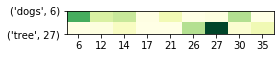

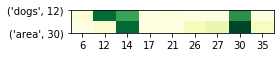

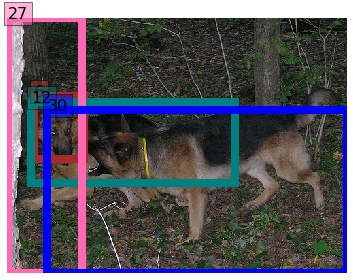

two dogs are playing in a tree.
two dogs are playing in a wooded area.


In [218]:
# This for caption model attention vis.    
plt.figure(figsize=[4,2])
# plt.figure()
ax=plt.gca()
ax.imshow(cap_attn_np_sample, cmap="YlGn")
ax.set_yticks(np.arange(len(cap_att_ground)))
# ax.set_xticks(np.arange(36))
ax.set_xticks(np.arange(9))
ax.set_xticklabels(xticks)
ax.set_yticklabels(zip(objects,cap_att_ground))
plt.tight_layout()


# This for caption model attention vis.    
plt.figure(figsize=[4,2])
# plt.figure()
ax=plt.gca()
ax.imshow(cap_attn_np_sample2, cmap="YlGn")
ax.set_yticks(np.arange(len(cap_att_ground2)))
# ax.set_xticks(np.arange(36))
ax.set_xticks(np.arange(9))
ax.set_xticklabels(xticks)
ax.set_yticklabels(zip(objects2,cap_att_ground2))
plt.tight_layout()

color_list = ['m', 'c', 'y', 'orange', 'hotpink', 'm', 'brown', 'm', 'r','r', 'lime', 'r', 'teal','skyblue', 'r', 'navy', 'mediumpurple', 'indigo', 'violet', 'crimson', 'b', 'olive', 'fuchsia', 'm', 'c', 'y', 'orange', 'hotpink', 'k', 'dodgerblue','b','red','red','r', 'g','blue']
# color_list=list(matplotlib.colors.cnames.keys())[:36]
plt.figure()
ax=plt.gca()
ax.imshow(image)
for ix, bbox in enumerate(box.tolist()):
#     if ix in cap_att_ground:
    if ix in fix and ix!=33:
        box_plot = patches.Rectangle((bbox[0],bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1, fill=False, edgecolor=color_list[ix], linewidth=8)
        ax.text(bbox[0],bbox[1],str(ix), bbox={'facecolor':color_list[ix], 'alpha':0.5},fontsize=16)
        ax.add_patch(box_plot)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close('all')
print(' '.join(caption)+'.')
print(' '.join(caption2)+'.')

In [56]:
# # This for scan attention vis.    
# plt.figure(figsize=[8,5])
# ax=plt.gca()
# ax.imshow(scan_attn_np, cmap="YlGn")
# ax.set_yticks(np.arange(len(scan_att_ground)))
# ax.set_xticks(np.arange(36))
# ax.set_yticklabels(zip(objects,scan_att_ground))
# plt.tight_layout()

# color_list = ['m', 'c', 'y', 'orange', 'hotpink', 'k', 'brown', 'peru', 'gold','darkseagreen', 'lime', 'lightseagreen', 'darkslategrey','skyblue', 'slategrey', 'navy', 'mediumpurple', 'indigo', 'violet', 'crimson', 'tomato', 'olive', 'fuchsia', 'm', 'c', 'y', 'orange', 'hotpink', 'k', 'aliceblue','antiquewhite','red','red','black', 'blanchedalmond','blue']
# # color_list=list(matplotlib.colors.cnames.keys())[:36]
# plt.figure()
# ax=plt.gca()
# ax.imshow(image)
# for ix, bbox in enumerate(box.tolist()):
#     if ix in scan_att_ground:
#         box_plot = patches.Rectangle((bbox[0],bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1, fill=False, edgecolor=color_list[ix], linewidth=2)
#         ax.text(bbox[0],bbox[1],str(ix), bbox={'facecolor':color_list[ix], 'alpha':0.5})
#         ax.add_patch(box_plot)
# plt.axis('off')
# plt.tight_layout()
# plt.show()
# plt.close('all')
# print(caption)


36